In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict



In [13]:
def convert_unix_to_timestamp(data):
    """
    Recursively converts UNIX timestamps to ISO 8601 format in JSON data.
    """
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, dict) and "$date" in value and isinstance(value["$date"], (int, float)):
                # Convert UNIX timestamp to ISO 8601 format
                value["$date"] = datetime.utcfromtimestamp(value["$date"] / 1000).isoformat()
            else:
                convert_unix_to_timestamp(value)  # Process nested structures
    elif isinstance(data, list):
        for item in data:
            convert_unix_to_timestamp(item)

# File paths
input_file = "brands.json"  # Input file containing raw JSON
output_file = "structured_data/brands.json"  # Output file for cleaned data

try:
    valid_json_objects = []

    # Read and process each line from the file
    with open(input_file, "r") as file:
        for line in file:
            line = line.strip()
            if line:  # Skip empty lines
                try:
                    json_obj = json.loads(line)  # Parse JSON lines
                    valid_json_objects.append(json_obj)
                except json.JSONDecodeError:
                    print(f"Skipping invalid JSON line: {line}")

    # Convert timestamps in the JSON objects
    convert_unix_to_timestamp(valid_json_objects)

    # Write the cleaned data to the output file
    with open(output_file, "w") as file:
        json.dump(valid_json_objects, file, indent=4)

    print(f"File successfully fixed and timestamps converted! Saved as {output_file}")

except Exception as e:
    print(f"An error occurred: {e}")


File successfully fixed and timestamps converted! Saved as structured_data/bss.json


Missing Values in Columns:
                     Column  Missing Values  Percentage (%)
7         pointsAwardedDate             582       52.010724
1         bonusPointsEarned             575       51.385165
2   bonusPointsEarnedReason             575       51.385165
5              finishedDate             551       49.240393
8              pointsEarned             510       45.576408
10       purchasedItemCount             484       43.252904
9              purchaseDate             448       40.035746
11   rewardsReceiptItemList             440       39.320822
13               totalSpent             435       38.873995


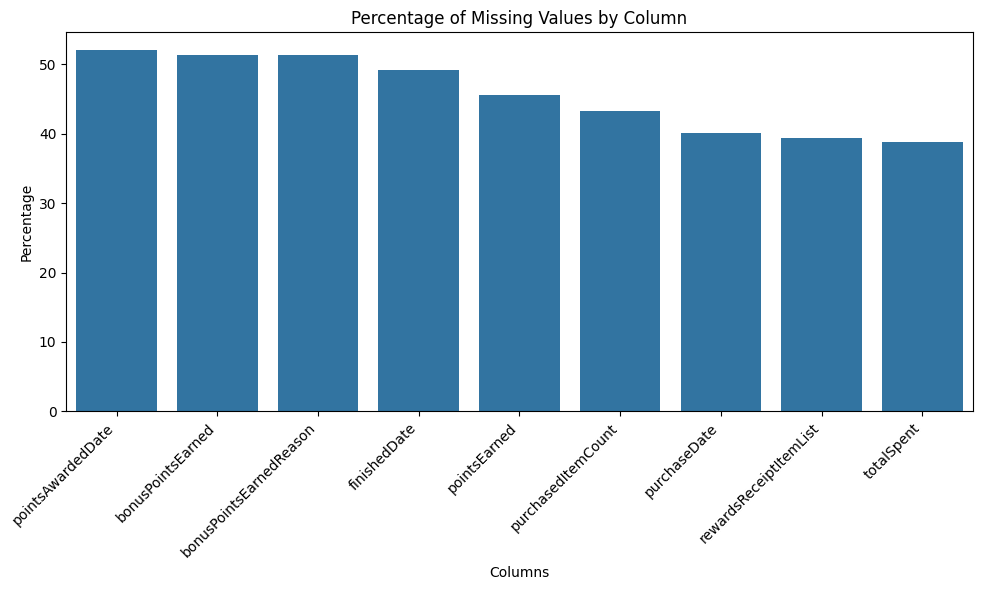

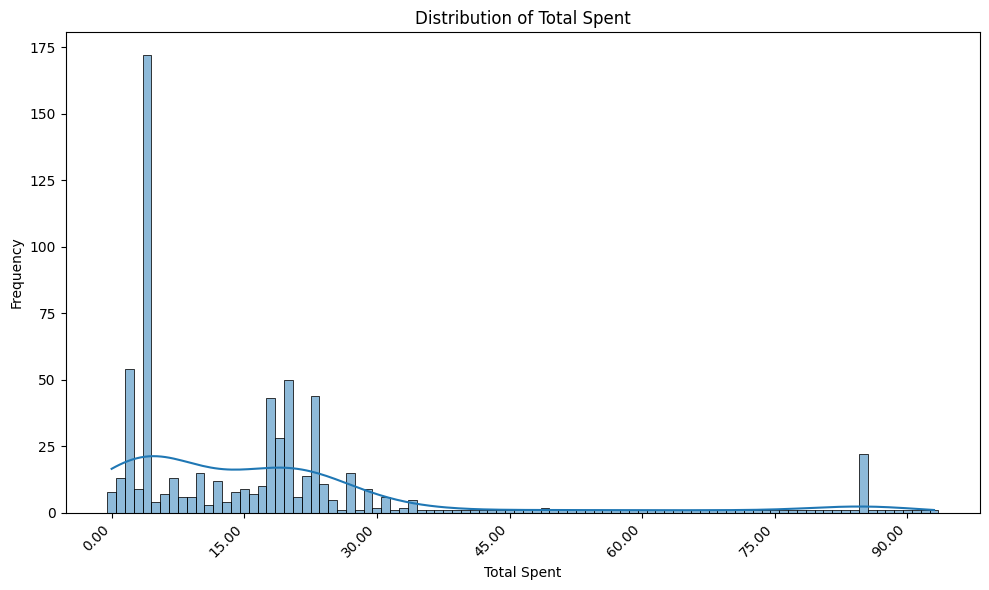

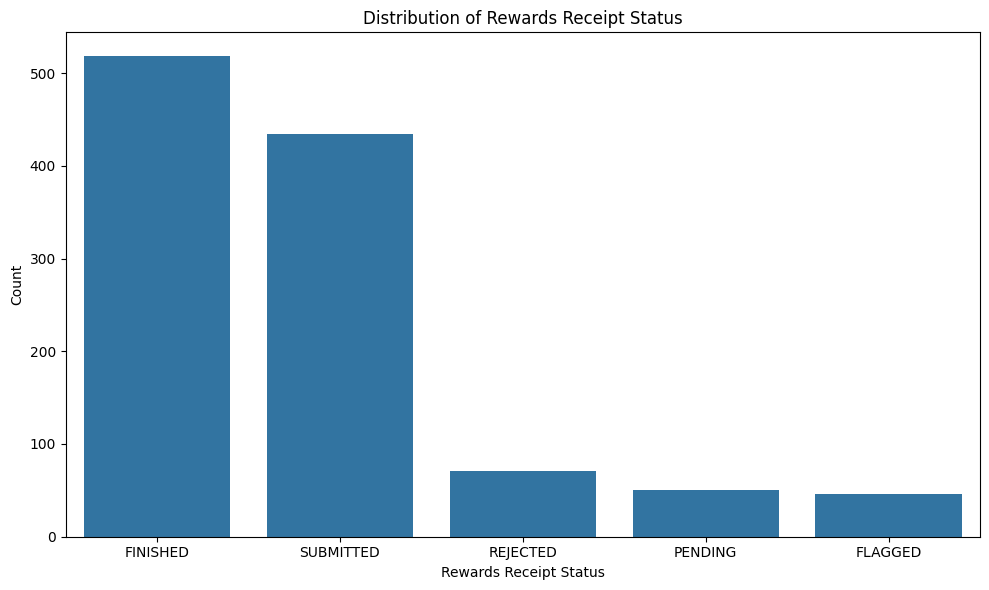

Numeric Summary of Data:
       bonusPointsEarned  purchasedItemCount
count         544.000000           635.00000
mean          238.893382            14.75748
std           299.091731            61.13424
min             5.000000             0.00000
25%             5.000000             1.00000
50%            45.000000             2.00000
75%           500.000000             5.00000
max           750.000000           689.00000


In [29]:
# Receipts Data Quality Analysis Function
def analyze_data_quality(receipt):
    """
    Analyzes a single receipt for data quality issues.
    Returns a list of identified issues.
    """
    issues = []
    
    # Check for missing critical fields
    critical_fields = ['_id', 'userId', 'totalSpent', 'purchaseDate', 'rewardsReceiptStatus']
    for field in critical_fields:
        if field not in receipt or receipt[field] is None:
            issues.append(f"Missing critical field: {field}")
    
    # Validate date fields
    date_fields = ['createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']
    current_date = datetime(2025, 1, 24, 12, 0)
    
    for field in date_fields:
        if field in receipt and receipt[field]:
            try:
                field_date = datetime.fromtimestamp(receipt[field]['$date'] / 1000)
                if field_date > current_date:
                    issues.append(f"Future date in {field}: {field_date}")
            except Exception:
                issues.append(f"Invalid date format in {field}")
    
    # Validate numeric fields
    numeric_fields = ['totalSpent', 'pointsEarned', 'bonusPointsEarned']
    for field in numeric_fields:
        if field in receipt:
            try:
                value = float(receipt[field])
                if value < 0:
                    issues.append(f"Negative value in {field}: {value}")
            except ValueError:
                issues.append(f"Non-numeric value in {field}: {receipt.get(field)}")
    
    # Check receipt item list consistency
    if 'rewardsReceiptItemList' in receipt:
        item_list = receipt['rewardsReceiptItemList']
        barcodes = [item.get('barcode') for item in item_list if 'barcode' in item]
        if len(barcodes) != len(set(barcodes)):
            issues.append("Receipt contains duplicate items")
        
        for item in item_list:
            try:
                item_price = float(item.get('itemPrice', 0))
                if item_price < 0:
                    issues.append(f"Negative item price: {item_price}")
            except ValueError:
                issues.append(f"Non-numeric item price: {item.get('itemPrice')}")
    
    # Check receipt status consistency
    if receipt.get('rewardsReceiptStatus') == 'FINISHED' and 'finishedDate' not in receipt:
        issues.append("FINISHED status without finishedDate")
    
    return issues

# Load and analyze JSON data
file_path = 'structured_data/receipts.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Analyze Data Quality
all_issues = defaultdict(list)
for receipt in data:
    receipt_issues = analyze_data_quality(receipt)
    for issue in receipt_issues:
        all_issues[receipt['_id']['$oid']].append(issue)

# Convert JSON Data to DataFrame for EDA
data_df = pd.DataFrame(data)

# Missing Values Analysis
missing_values = data_df.isnull().sum()
missing_values_percent = (missing_values / len(data_df)) * 100
missing_values_table = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Values': missing_values.values,
    'Percentage (%)': missing_values_percent.values
}).sort_values(by='Missing Values', ascending=False)

missing_values_table = missing_values_table[missing_values_table['Missing Values'] > 0]
print("Missing Values in Columns:")
print(missing_values_table)

# Visualizing Missing Values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values_table['Column'], y=missing_values_table['Percentage (%)'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

# Numeric Field Distribution
if 'totalSpent' in data_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_df['totalSpent'].dropna(), kde=True, bins=30)
    plt.title('Distribution of Total Spent')
    plt.xlabel('Total Spent')
    plt.ylabel('Frequency')

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.2f}'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Categorical Field Distribution
if 'rewardsReceiptStatus' in data_df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data_df, x='rewardsReceiptStatus', order=data_df['rewardsReceiptStatus'].value_counts().index)
    plt.title('Distribution of Rewards Receipt Status')
    plt.xlabel('Rewards Receipt Status')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Descriptive Statistics
numeric_summary = data_df.describe()
print("Numeric Summary of Data:")
print(numeric_summary)


Brand Data Quality Issues:
                      Brand ID                                        Issue
0     601ac115be37ce2ead437551                  Missing required field: cpg
1     601ac115be37ce2ead437551     Empty or null value for field: brandCode
2     601c5460be37ce2ead43755f                  Missing required field: cpg
3     601ac142be37ce2ead43755d                  Missing required field: cpg
4     601ac142be37ce2ead43755a                  Missing required field: cpg
...                        ...                                          ...
2985  5f494c6e04db711dd8fe87e7      Empty or null value for field: topBrand
2986  5f494c6e04db711dd8fe87e7         Mismatched category and categoryCode
2987  5a021611e4b00efe02b02a57                  Missing required field: cpg
2988  5a021611e4b00efe02b02a57  Empty or null value for field: categoryCode
2989  6026d757be37ce6369301468                  Missing required field: cpg

[2990 rows x 2 columns]

Missing Value Summary:
            

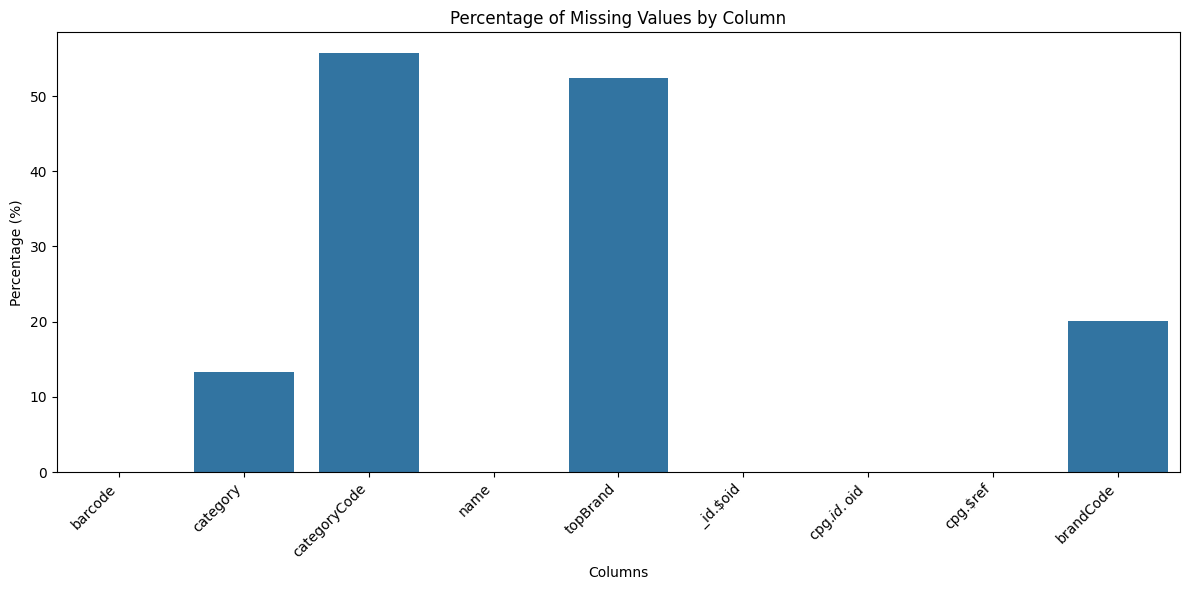

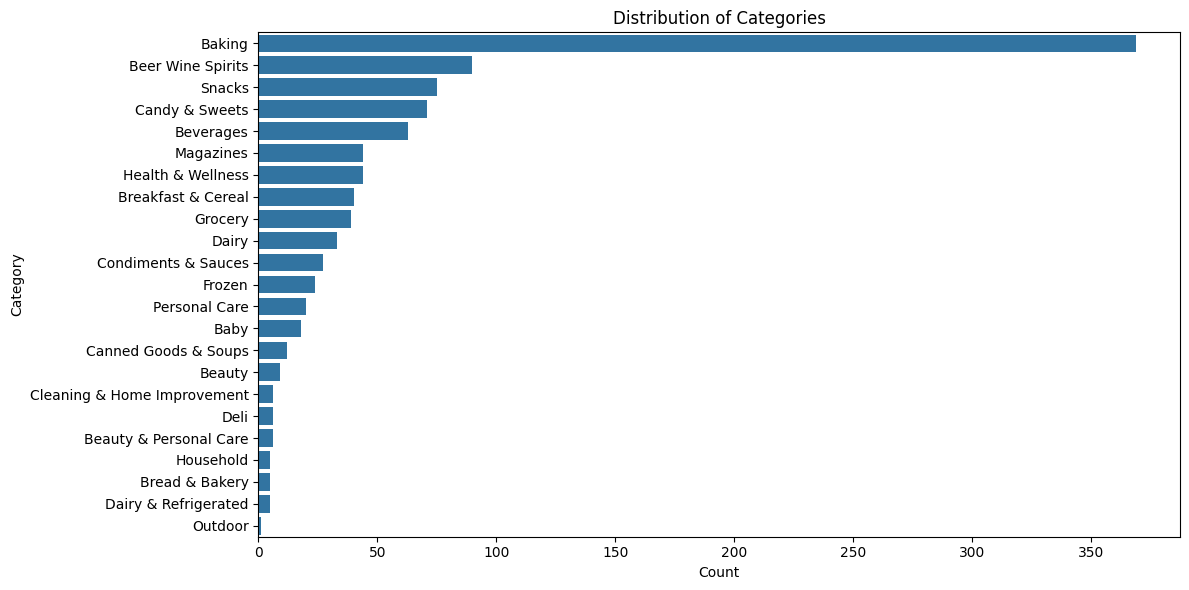

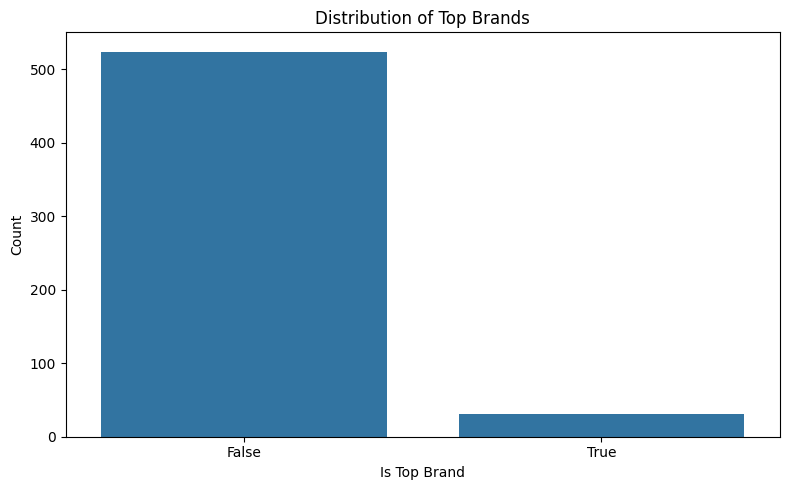

In [31]:
# Load the JSON data
file_path = 'structured_data/brands.json'
with open(file_path, 'r') as file:
    brands_data = json.load(file)

# Load the data into a DataFrame
df = pd.json_normalize(brands_data)

# Data Quality Analysis Function
def analyze_brands_data(dataframe):
    all_issues = defaultdict(list)
    barcodes = defaultdict(list)
    names = defaultdict(list)

    for index, brand in dataframe.iterrows():
        brand_id = brand['_id.$oid']
        issues = []

        # Check for missing required fields
        required_fields = ['_id.$oid', 'name', 'cpg']
        for field in required_fields:
            if pd.isnull(brand.get(field, None)):
                issues.append(f"Missing required field: {field}")

        # Check for empty or null values
        for column, value in brand.items():
            if pd.isnull(value) or (isinstance(value, str) and value.strip() == ''):
                issues.append(f"Empty or null value for field: {column}")

        # Check for inconsistent data types
        if 'topBrand' in dataframe.columns and not pd.isnull(brand.get('topBrand')):
            if not isinstance(brand['topBrand'], bool):
                issues.append("Inconsistent data type for topBrand (should be boolean)")

        # Check for invalid category codes
        if 'categoryCode' in dataframe.columns and isinstance(brand.get('categoryCode'), str):
            if not brand['categoryCode'].isupper():
                issues.append("Invalid category code format (should be uppercase)")

        # Check for mismatched category and categoryCode
        if 'category' in dataframe.columns and 'categoryCode' in dataframe.columns:
            category = brand.get('category', '')
            category_code = brand.get('categoryCode', '')

            if pd.notnull(category) and pd.notnull(category_code):
                if str(category).upper().replace(' ', '_') != str(category_code):
                    issues.append("Mismatched category and categoryCode")

        # Collect data for duplicate checks
        if 'barcode' in dataframe.columns and not pd.isnull(brand.get('barcode')):
            barcodes[brand['barcode']].append(brand_id)
        if 'name' in dataframe.columns and not pd.isnull(brand.get('name')):
            names[brand['name']].append(brand_id)

        if issues:
            all_issues[brand_id].extend(issues)

    # Identify duplicate barcodes and names
    for barcode, ids in barcodes.items():
        if len(ids) > 1:
            for brand_id in ids:
                all_issues[brand_id].append(f"Duplicate barcode: {barcode}")
    for name, ids in names.items():
        if len(ids) > 1:
            for brand_id in ids:
                all_issues[brand_id].append(f"Duplicate name: {name}")

    return all_issues

# Analyze data quality
all_issues = analyze_brands_data(df)

# Summarize issues
issues_summary = pd.DataFrame([(key, issue) for key, issues in all_issues.items() for issue in issues], columns=['Brand ID', 'Issue'])
print("Brand Data Quality Issues:")
print(issues_summary)

# Missing Values Analysis
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values, 'Percentage (%)': missing_percent})
print("\nMissing Value Summary:")
print(missing_summary)

# Visualizing Missing Values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_summary['Column'], y=missing_summary['Percentage (%)'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

# Distribution of Categories
if 'category' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, y='category', order=df['category'].value_counts().index)
    plt.title('Distribution of Categories')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.tight_layout()
    plt.show()

# Analyze 'topBrand' Field
if 'topBrand' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='topBrand')
    plt.title('Distribution of Top Brands')
    plt.xlabel('Is Top Brand')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()



Missing Value Summary:
                    Column  Missing Values  Percentage (%)
lastLogin        lastLogin              62       12.550607
state                state              56       11.336032
signUpSource  signUpSource              48        9.716599
createdDate    createdDate               6        1.214575
active              active               0        0.000000
role                  role               0        0.000000
id                      id               0        0.000000


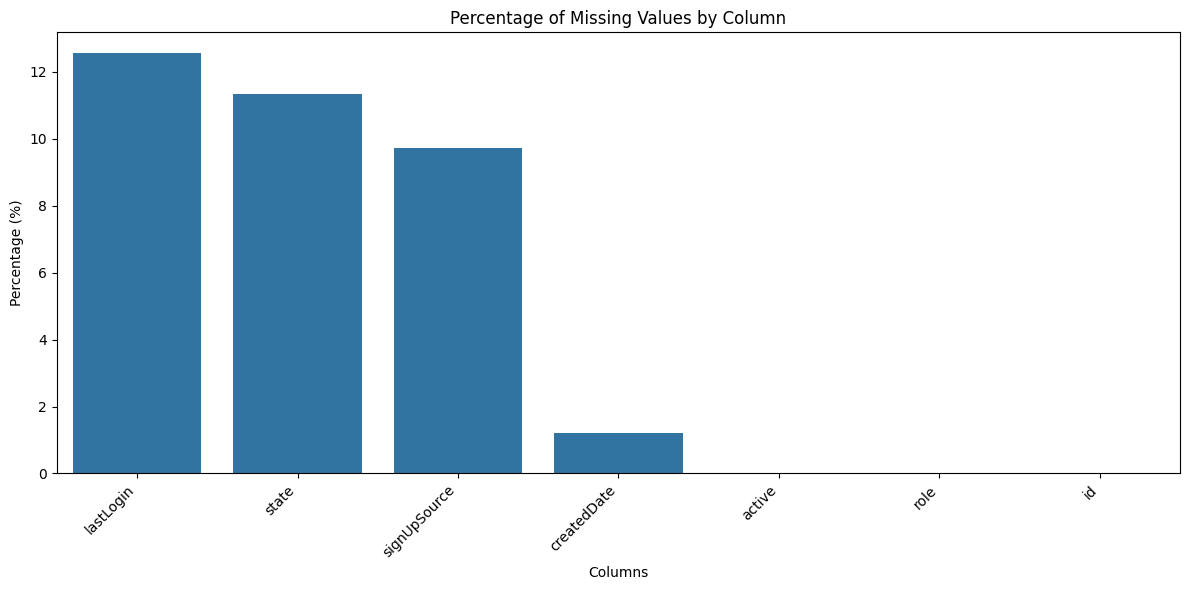


Number of duplicate user IDs: 282


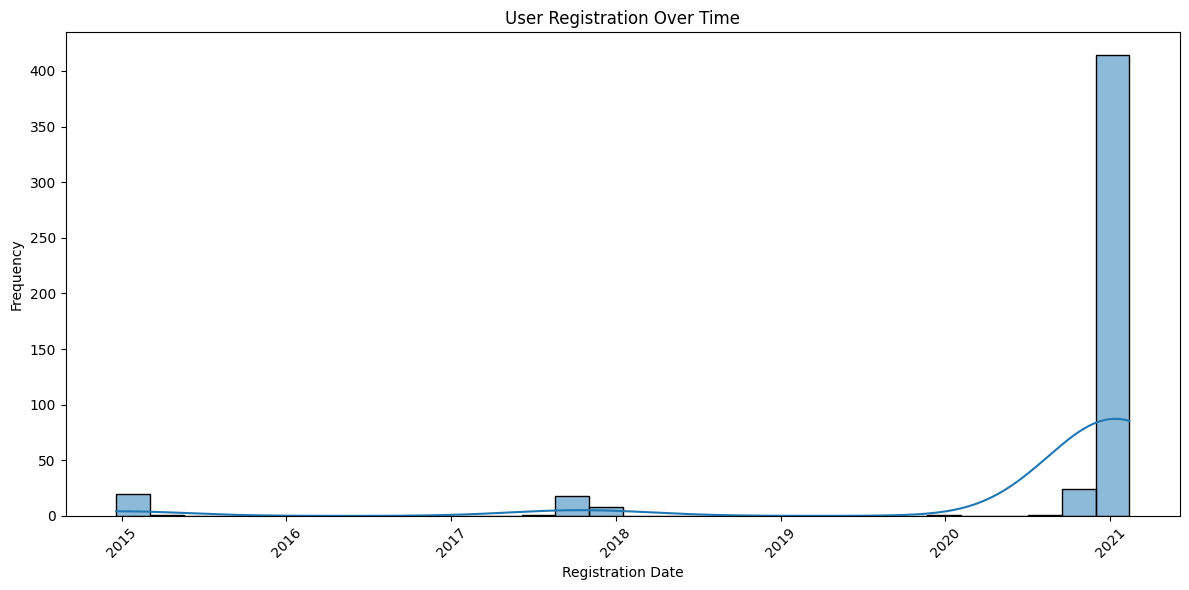

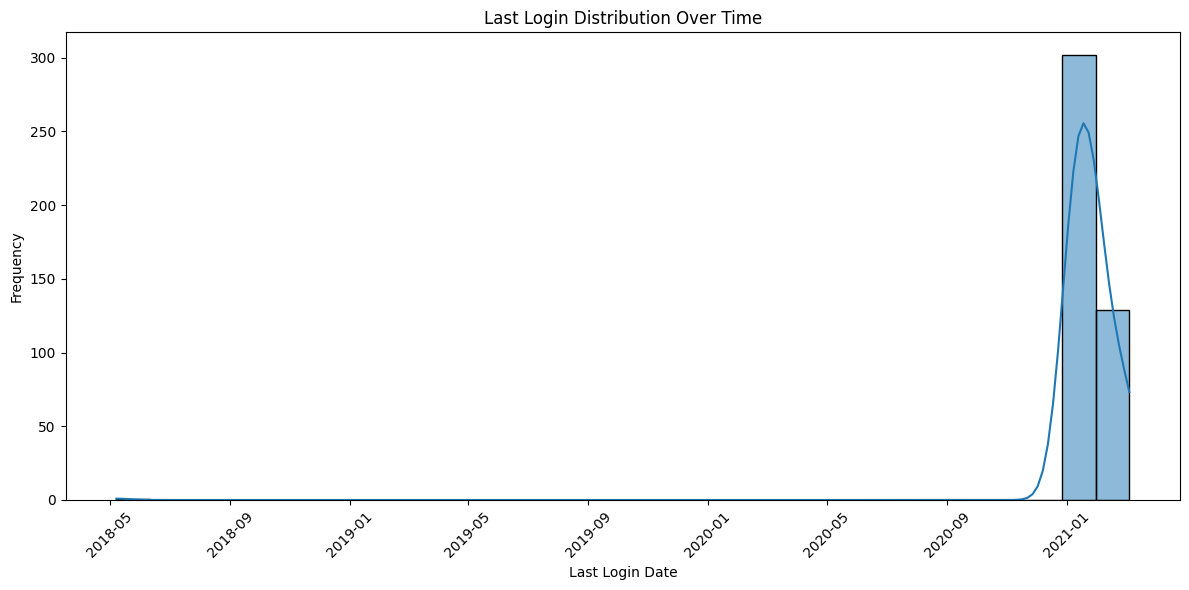

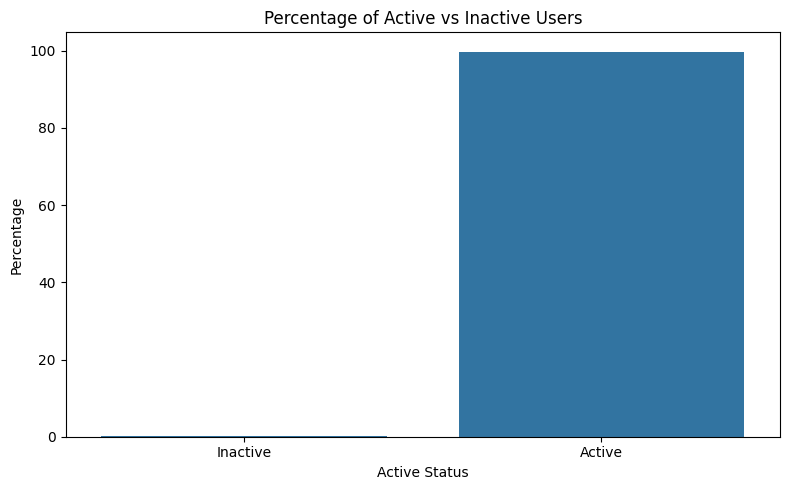

In [32]:
# Load JSON Data
file_path = 'structured_data/users.json'
with open(file_path, 'r') as file:
    try:
        users_data = json.load(file)
    except json.JSONDecodeError as e:
        print("Failed to load JSON file:", e)
        users_data = []

# Convert JSON Data to DataFrame
df = pd.json_normalize(users_data)

# Rename columns for simplicity
df.rename(columns={
    '_id.$oid': 'id',
    'createdDate.$date': 'createdDate',
    'lastLogin.$date': 'lastLogin'
}, inplace=True)

# Convert string timestamps to datetime
df['createdDate'] = pd.to_datetime(df['createdDate'], errors='coerce')
df['lastLogin'] = pd.to_datetime(df['lastLogin'], errors='coerce')

# Missing Values Analysis
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Values': missing_values.values,
    'Percentage (%)': missing_percent
}).sort_values(by='Missing Values', ascending=False)

print("\nMissing Value Summary:")
print(missing_summary)

# Visualizing Missing Values
plt.figure(figsize=(12, 6))
sns.barplot(x='Column', y='Percentage (%)', data=missing_summary)
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

# Duplicate Entries Analysis
duplicates = df.duplicated(subset='id').sum()
print(f"\nNumber of duplicate user IDs: {duplicates}")

# Visualizing Date Distributions
if 'createdDate' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(df['createdDate'].dropna(), bins=30, kde=True)
    plt.title('User Registration Over Time')
    plt.xlabel('Registration Date')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if 'lastLogin' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(df['lastLogin'].dropna(), bins=30, kde=True)
    plt.title('Last Login Distribution Over Time')
    plt.xlabel('Last Login Date')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualizing Active User Percentage
if 'active' in df.columns:
    active_counts = df['active'].value_counts(normalize=True) * 100
    plt.figure(figsize=(8, 5))
    sns.barplot(x=active_counts.index, y=active_counts.values)
    plt.title('Percentage of Active vs Inactive Users')
    plt.xlabel('Active Status')
    plt.ylabel('Percentage')
    plt.xticks([0, 1], ['Inactive', 'Active'])
    plt.tight_layout()
    plt.show()
